# From Scratch

In [37]:
import numpy as np
from scipy import signal

## Activations

In [38]:
class Activation():
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_grad, learning_rate):
        return np.multiply(output_grad, self.activation_prime(self.input))
    
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)
        
        def tanh_prime(x):
            return 1 - np.tanh(x)**2
        
        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))
        
        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)
        
        def relu_prime(x):
            return np.where(x <= 0, 0, 1)
        
        super().__init__(relu, relu_prime)

class Softmax():
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

## Losses

In [39]:
import numpy as np

def categorical_cross_entropy(y_true, y_pred):
    """
    Compute the categorical cross-entropy loss.
    
    Parameters:
        y_true (numpy.ndarray): True labels (one-hot encoded).
        y_pred (numpy.ndarray): Predicted probability distributions.
        
    Returns:
        float: Categorical cross-entropy loss.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Clip predicted values to avoid log(0) errors
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred))
    
    # Average loss over samples
    loss /= len(y_true)
    
    return loss

def categorical_cross_entropy_prime(y_true, y_pred):
    """
    Compute the gradient of the categorical cross-entropy loss with respect to the predicted values.
    
    Parameters:
        y_true (numpy.ndarray): True labels (one-hot encoded).
        y_pred (numpy.ndarray): Predicted probability distributions.
        
    Returns:
        numpy.ndarray: Gradient of the categorical cross-entropy loss with respect to the predicted values.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Clip predicted values to avoid log(0) errors
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute gradient of cross-entropy loss
    gradient = -y_true / y_pred
    
    return gradient

## Convolutional Layer

In [40]:
class ConvolutionalLayer():
    '''
    Convolutional layer class

    Attributes:
    input_shape: tuple
        The shape of the input data - (input_depth, input_height, input_width)
    output_depth: int
        The depth of the output data
    kernel_size: int or tuple
        The size of the kernel
    padding: int or tuple
        The padding to be applied to the input data
    stride: int or tuple
        The stride to be applied to the input data
    bias: bool
        Whether to use bias or not

    Methods:
    forward(input)
        Forward pass of the layer
    backward(output_gradient, learning_rate)
        Backward pass of the layer
    '''
    def __init__(self, input_shape:tuple, output_depth:int, kernel_size, padding=0, stride=1, bias:bool=True):
        self.input_depth, input_height, input_width = input_shape
        self.output_depth = output_depth
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.bias = bias

        assert isinstance(kernel_size, (int, tuple)), "kernel_size should be int or tuple"
        assert isinstance(padding, (int, tuple)), "padding should be int or tuple"
        assert isinstance(stride, (int, tuple)), "stride should be int or tuple"

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        if isinstance(padding, int):
            self.padding = (padding, padding)
        if isinstance(stride, int):
            self.stride = (stride, stride)

        self.kernels_shape = (output_depth, self.input_depth, self.kernel_size[0], self.kernel_size[1])
        self.output_shape = (output_depth, int((input_height - self.kernel_size[0] + 2*self.padding[0] + self.stride[0]) / self.stride[0]), int((input_width - self.kernel_size[1] + 2*self.padding[1] + self.stride[0]) / self.stride[0]))
        self.dilated_gradient_shape = (output_depth, (input_height - self.kernel_size[0] + 2*self.padding[0] + 1), (input_width - self.kernel_size[1] + 2*self.padding[1] + 1))

        # Initialise weights
        self.weights = np.random.randn(output_depth, self.input_depth, self.kernel_size[0], self.kernel_size[1])
        
        # Initialise bias
        if self.bias:
            self.biases = np.random.randn(*self.output_shape)
        else:
            self.biases = np.zeros(*self.output_shape)

    def forward(self, input):     
        # Padding
        input = np.pad(input, ((0, 0), (self.padding[0], self.padding[0]), (self.padding[1], self.padding[1])))
        self.input = input

        # Calculate output
        self.output = np.copy(self.biases)
        for i in range(self.output_depth):
            for j in range(self.input_depth):
                # Cross correlation
                self.output[i] += signal.correlate2d(input[j], self.weights[i, j], "valid")[::self.stride[0], ::self.stride[1]]
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input.shape)

        # Initialise dilated output gradient matrix
        dilated_output_gradient = np.zeros(self.dilated_gradient_shape)

        for i in range(self.output_depth):
            
            # Make the dilated output gradient
            for index_x, row in enumerate(output_gradient[i]):
                for index_y, gradient in enumerate(row):
                    dilated_output_gradient[i, index_x * (self.stride[0]), index_y * (self.stride[1])] = gradient

            # Calculate the gradients
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], dilated_output_gradient[i], "valid")[::self.stride[0], ::self.stride[1]]
                input_gradient[j] += signal.convolve2d(dilated_output_gradient[i], self.weights[i, j], "full")

        # Update the weights
        self.weights -= learning_rate * kernels_gradient

        # Update the biases if needed
        if self.bias:
            self.biases -= learning_rate * output_gradient

        # Crop the padding gradients
        if self.padding[0] != 0:
            input_gradient = input_gradient[:, self.padding[0]:-self.padding[0], :]
        if self.padding[1] != 0:
            input_gradient = input_gradient[:, :, self.padding[1]:-self.padding[1]]

        return input_gradient

## Pooling Layer

In [41]:
class MaxPooling():
    '''
    Max pooling layer class

    Attributes:
    input_shape: tuple
        The shape of the input data - (input_depth, input_height, input_width)
    kernel_size: int or tuple
        The size of the kernel
    padding: int or tuple
        The padding to be applied to the input data
    stride: int or tuple
        The stride to be applied to the input data

    Methods:
    forward(input)
        Forward pass of the layer
    backward(output_gradient, learning_rate)
        Backward pass of the layer
    '''
    def __init__(self, input_shape:tuple, kernel_size, padding, stride):
        self.input_depth, input_height, input_width = input_shape
        self.output_depth = self.input_depth
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        assert isinstance(kernel_size, (int, tuple)), "kernel_size should be int or tuple"
        assert isinstance(padding, (int, tuple)), "padding should be int or tuple"
        assert isinstance(stride, (int, tuple)), "stride should be int or tuple"

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        if isinstance(padding, int):
            self.padding = (padding, padding)
        if isinstance(stride, int):
            self.stride = (stride, stride)

        self.output_shape = (self.output_depth, int((input_height - self.kernel_size[0] + 2*self.padding[0] + self.stride[0]) / self.stride[0]), int((input_width - self.kernel_size[1] + 2*self.padding[1] + self.stride[0]) / self.stride[0]))

    def forward(self, input):      
        # Padding
        input = np.pad(input, ((0, 0), (self.padding[0], self.padding[0]), (self.padding[1], self.padding[1])), constant_values=-np.inf)
        self.input = input

        # Calculate output
        self.output = np.zeros(self.output_shape)
        for i in range(self.output_depth):
            for x in range(self.output_shape[1]):
                for y in range(self.output_shape[2]):
                    self.output[i, x, y] = np.max(input[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]])

        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.zeros(self.input.shape)
        
        for i in range(self.output_depth):
            for x in range(self.output_shape[1]):
                for y in range(self.output_shape[2]):
                    window = self.input[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]]
                    max_value = np.max(window)
                    input_gradient[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]] += (window == max_value) * output_gradient[i, x, y]
        
        # Crop the padding gradients
        if self.padding[0] != 0:
            input_gradient = input_gradient[:, self.padding[0]:-self.padding[0], :]
        if self.padding[1] != 0:
            input_gradient = input_gradient[:, :, self.padding[1]:-self.padding[1]]

        return input_gradient

## Flatten (Reshape) Layer

In [42]:
class Reshape():
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

## Fully Connected Layer

In [43]:
class Dense():
    def __init__(self, input_size, output_size, bias:bool=True):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = bias
        if self.bias:
            self.biases = np.random.randn(output_size, 1)
        else:
            self.biases = np.zeros((output_size, 1))

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.biases

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        
        self.weights -= learning_rate * weights_gradient

        if self.bias:
            self.biases -= learning_rate * output_gradient

        return input_gradient

In [44]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, x_test, y_test, epochs = 1000, learning_rate = 0.01, batch_size = 32, verbose = True):
    errors = []
    test_scores = []
    for e in range(epochs):
        error = 0
        indices = np.random.permutation(len(x_train))[:batch_size]            
        for x, y in zip(x_train[indices], y_train[indices]):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= batch_size
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

        if e % 10 == 0:
            correct = 0
            indices = np.random.permutation(len(x_test))[:500]      
            for x, y in zip(x_test, y_test):
                output = predict(network, x)
                correct += np.argmax(output) == np.argmax(y)

            test_scores.append(correct / len(x_test))

        errors.append(error)
    
    return errors, test_scores

## Train on MNIST

In [45]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical

In [46]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Reshape the images data
train_images = np.expand_dims(train_images, axis=1)
test_images = np.expand_dims(test_images, axis=1)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Reshape the labels
train_labels = train_labels.reshape(-1, 10, 1)
test_labels = test_labels.reshape(-1, 10, 1)

In [47]:
# neural network
network = [
    ConvolutionalLayer((1, 28, 28), 2, 5),
    ReLU(),
    MaxPooling((2, 24, 24), 2, 0, 2),
    ConvolutionalLayer((2, 12, 12), 4, 3),
    Sigmoid(),
    MaxPooling((4, 10, 10), 2, 0, 2),
    Reshape((4, 5, 5), (4 * 5 * 5, 1)),
    Dense(4 * 5 * 5, 10),
    Softmax()
]

# train
errors, test_scores = train(
    network,
    categorical_cross_entropy,
    categorical_cross_entropy_prime,
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=500,
    learning_rate=0.05,
    batch_size=128,
)

# test
correct = 0
for x, y in zip(test_images, test_labels):
    output = predict(network, x)
    correct += np.argmax(output) == np.argmax(y)

print(f"Accuracy: {correct / len(test_images) * 100:.2f}%")

1/500, error=0.348423805883121
2/500, error=0.3048005599274123
3/500, error=0.27669820550233415
4/500, error=0.27677737643131944
5/500, error=0.2628336562556142
6/500, error=0.26311696959278474
7/500, error=0.23914059009437777
8/500, error=0.250220733902089
9/500, error=0.22757779490037242
10/500, error=0.25912505968068794
11/500, error=0.18706971822825738
12/500, error=0.1780712255434348
13/500, error=0.19496914880143582
14/500, error=0.18702963853185428
15/500, error=0.1667842797308851
16/500, error=0.1638461304384624
17/500, error=0.1605599900254474
18/500, error=0.20332790504675702
19/500, error=0.13384421280782835
20/500, error=0.1355720165761884
21/500, error=0.13580131679975171
22/500, error=0.14551103856957628
23/500, error=0.1261929781855669
24/500, error=0.09725870165230557
25/500, error=0.12146662182059066
26/500, error=0.13647467853560952
27/500, error=0.12252881942316524
28/500, error=0.10541363564492617
29/500, error=0.1062974920842765
30/500, error=0.12187944700693237
31

C:\Users\Viktor\AppData\Local\Temp\ipykernel_25484\3325793307.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


277/500, error=0.034136801964910556
278/500, error=0.03702659462033399
279/500, error=0.04618072368446978
280/500, error=0.05725827609238114
281/500, error=0.049014525646230045
282/500, error=0.04680394092500641
283/500, error=0.022838500662080676
284/500, error=0.03280827799350064
285/500, error=0.04439915331127282
286/500, error=0.04302496347646414
287/500, error=0.04500168704292025
288/500, error=0.03471952516355471
289/500, error=0.038722499623904616
290/500, error=0.025343429487055313
291/500, error=0.02441499692930696
292/500, error=0.03225287581512576
293/500, error=0.03663945387895194
294/500, error=0.04070969877736537
295/500, error=0.04116822250746225
296/500, error=0.0408021136837075
297/500, error=0.05342775919848235
298/500, error=0.03854178040288229
299/500, error=0.050361945242366674
300/500, error=0.05575970474654589
301/500, error=0.032248390238666984
302/500, error=0.03661503651994581
303/500, error=0.03817625256306516
304/500, error=0.05728270270596599
305/500, error

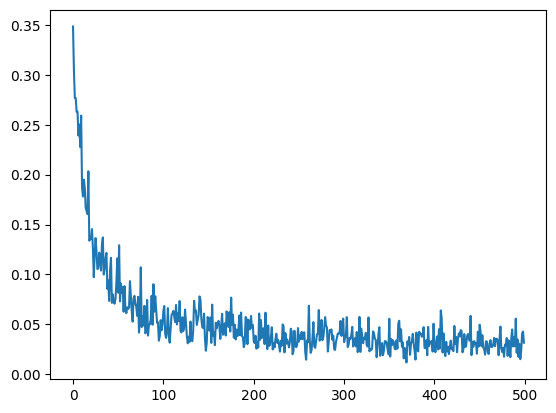

In [50]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(errors)

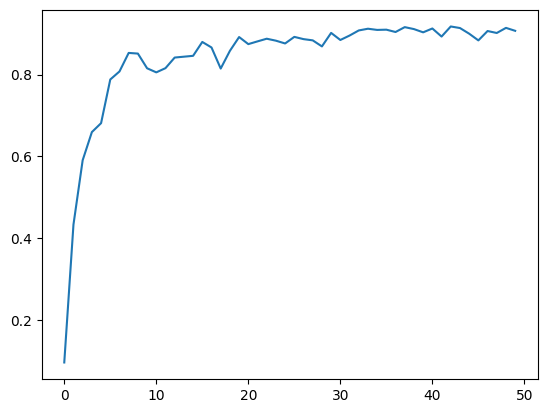

In [51]:
plt.plot(test_scores)

## Adversarial Attack - FGSM

In [133]:
digit_id = 150
digit = test_images[digit_id]
label = test_labels[digit_id]

output = predict(network, digit)

grad = categorical_cross_entropy_prime(label, output)
for layer in reversed(network):
    grad = layer.backward(grad, 0)

perturbations = np.sign(grad)
perturbations = perturbations * 0.5 + 0.5

epsilons = [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.75]

print(f"True label: {np.argmax(label)}")

for i, eps in enumerate(epsilons):
  adv_x = digit + eps * perturbations
  adv_x = np.clip(adv_x, 0, 1)
  
  preds = predict(network, np.reshape(adv_x, (1, 28, 28)))
  print(f"Epsilon: {eps}")
  print(f"\tPrediction: {np.argmax(preds)}")
  print(f"\tCertainty: {np.max(preds) * 100:.2f}%")
  print(f"\tL2 distance: {np.linalg.norm(preds - label)}")

True label: 9
Epsilon: 0
	Prediction: 9
	Certainty: 99.96%
	L2 distance: 0.0004865451963160343
Epsilon: 0.01
	Prediction: 9
	Certainty: 99.95%
	L2 distance: 0.0006758135456688812
Epsilon: 0.05
	Prediction: 9
	Certainty: 92.76%
	L2 distance: 0.09953744669687088
Epsilon: 0.1
	Prediction: 8
	Certainty: 74.55%
	L2 distance: 1.1510107151540794
Epsilon: 0.3
	Prediction: 5
	Certainty: 85.07%
	L2 distance: 1.3163390477109944
Epsilon: 0.5
	Prediction: 5
	Certainty: 84.23%
	L2 distance: 1.3135778443335044
Epsilon: 0.75
	Prediction: 5
	Certainty: 95.83%
	L2 distance: 1.385276684837859
